## Eraser

Verify whether CUDA is available

In [35]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


1. Define input image and the mask

In [36]:
from PIL import Image

input_path = '../inputs/eraser/bread.png'
mask_path = '../inputs/eraser/bread_mask.png'

input_image = Image.open(input_path)
mask_image = Image.open(mask_path)

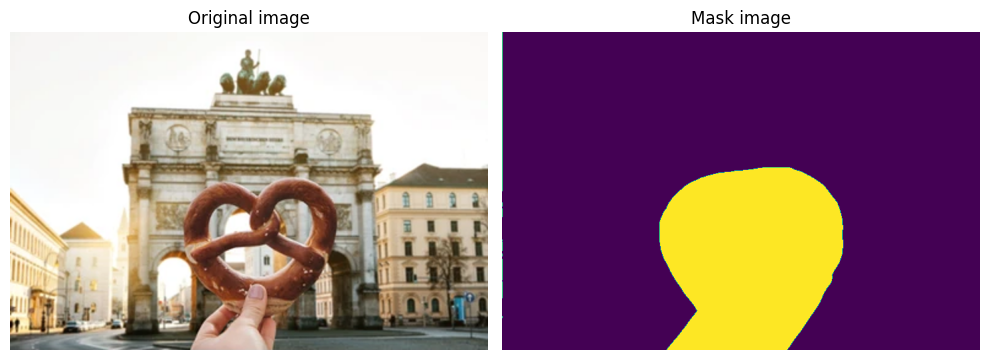

In [37]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(input_image)
axs[0].axis('off')  # Hide the axis
axs[0].set_title('Original image')  # Optionally set a title

# Display the second image in the right subplot
axs[1].imshow(mask_image)
axs[1].axis('off')  # Hide the axis
axs[1].set_title('Mask image')  # Optionally set a title

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

2. Define the number of DDIM steps for generation

In [38]:
ddim_steps = 50

3. Resize the original image to $512$ x $512$, which is necessary for the model

In [39]:
image = input_image
original_width, original_height = image.size

if original_width > original_height:
    image = image.resize((768, 512))
elif original_width < original_height:
    image = image.resize((512, 768))
else:
    image = image.resize((512, 512))

4. Resize the mask image to $512$ x $512$

In [40]:
mask = mask_image

mask_original_width, mask_original_height = mask.size

if mask_original_width > mask_original_height:
    mask = mask.resize((768, 512))
elif mask_original_width < mask_original_height:
    mask = mask.resize((512, 768))
else:
    mask = mask.resize((512, 512))

5. Set up the configuration and model paths

In [47]:
import os, sys
from omegaconf import OmegaConf
from tqdm import tqdm
import numpy as np

steps = int(ddim_steps)

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))

sys.path.append(os.path.join(parent_dir, 'latent-diffusion'))
sys.path.append(os.path.join(parent_dir, 'code'))

from main import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

config = OmegaConf.load("../models/ldm_inpainting/config.yaml")
model = instantiate_from_config(config.model)
model.load_state_dict(torch.load("../models/ldm_inpainting/last.ckpt")["state_dict"], strict=False)

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 387.25 M params.
Keeping EMAs of 418.
making attention of type 'none' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'none' with 512 in_channels
Using first stage also as cond stage.


_IncompatibleKeys(missing_keys=[], unexpected_keys=['ddim_sigmas', 'ddim_alphas', 'ddim_alphas_prev', 'ddim_sqrt_one_minus_alphas'])

In [51]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
sampler = DDIMSampler(model)

In [52]:
from eraser_ldm import make_batch_gradio

with torch.no_grad():
    with model.ema_scope():

        batch = make_batch_gradio(image, mask, device=device)

        c = model.cond_stage_model.encode(batch["masked_image"])
        cc = torch.nn.functional.interpolate(batch["mask"],
                                            size=c.shape[-2:])
        c = torch.cat((c, cc), dim=1)

        shape = (c.shape[1]-1,)+c.shape[2:]
        samples_ddim, _ = sampler.sample(S=steps, ## changed
                                        conditioning=c,
                                        batch_size=c.shape[0],
                                        shape=shape,
                                        verbose=False)
        x_samples_ddim = model.decode_first_stage(samples_ddim)

        image = torch.clamp((batch["image"]+1.0)/2.0,
                            min=0.0, max=1.0)
        mask = torch.clamp((batch["mask"]+1.0)/2.0,
                        min=0.0, max=1.0)
        predicted_image = torch.clamp((x_samples_ddim+1.0)/2.0,
                                    min=0.0, max=1.0)

        inpainted = (1-mask)*image+mask*predicted_image
        inpainted = inpainted.cpu().numpy().transpose(0,2,3,1)[0]*255
        inpainted = Image.fromarray(inpainted.astype(np.uint8))
        inpainted = inpainted.resize((original_width, original_height))

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 

6. Visualise the inpainted image

In [ ]:
plt.imshow(inpainted)
plt.axis('off')
plt.show()